In [ ]:
# default_exp model

# Word2Vec Model

> This module exposes classes and functions related to training of the Word2Vec recommender using the Gensim library.

https://radimrehurek.com/gensim/

In [ ]:
#hide
from nbdev.export import *

# adds library to context
import sys
sys.path.append('../')

In [ ]:
#export
import logging
import random
from typing import List, NamedTuple, Tuple
from datetime import datetime
from itertools import product
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec 
from gensim.models.callbacks import CallbackAny2Vec
from nbdev.showdoc import *
from tqdm import tqdm

from word2vec_recommender.core import *

In [ ]:
#export
logger = logging.getLogger(__name__)

In [ ]:
#export
class GensimParameters(NamedTuple):
    window: int = 10
    iter: int = 20
    sg: int = 1
    hs: int = 0
    negative: int = 10
    alpha: float = 0.03
    min_alpha: float = 0.0007
    seed: int = 14
    compute_loss: bool = True

In [ ]:
gensim_parameters = GensimParameters(window=10)

In [ ]:
#export
def generate_sentences_by_user(df: pd.DataFrame):
    """
    Generate the Gensin sentences for a dataframe.
    Each sentence is created by joining all ratings from a user sorted by timestamp.
    """
    def to_sentence(r):
        return [str(m) for m in r]
    return df.groupby('userId')['movieId'].apply(to_sentence).tolist()

In [ ]:
#export
class _EpochLogger(CallbackAny2Vec):
    """
    Log information about training, reports time for epochs.
    """
    def __init__(self, print_to_stdout: bool = False):
        """
        Constructor for the class to log progress information.
        """
        self._epoch = 1
        self._start = datetime.now()
        self._end = datetime.now()
        self._print_to_stdout = print_to_stdout

    def on_epoch_begin(self, _):
        """
        Print progress information, initializes start time.
        :param _: type gensim word2vec, signature to match the function to be used by gensim
        """
        self._start = datetime.now()
        msg = f"Epoch #{self._epoch} start"
        if self._print_to_stdout:
            print(msg)
        logger.info(msg)

    def on_epoch_end(self, model):
        """
        Print time to for epoch
        :param model: type gensim word2vec, signature to match the function to be used by gensim
        """
        self._end = datetime.now()
        elapsed = self._end - self._start
        msg = f"Epoch #{self._epoch} end in {elapsed} time"
        if self._print_to_stdout:
            print(msg)
        logger.info(msg)
        msg = f"Epoch #{self._epoch}, loss {model.get_latest_training_loss()}"
        if self._print_to_stdout:
            print(msg)
        logger.info(msg)
        self._epoch += 1


In [ ]:
#export
class Word2VecMovieModel:
    """
    This class encapsulates the training of recommendations plus utilities for persistance and predictions
    """
    def __init__(
        self,
        movies_df: pd.DataFrame,
        ratings_df: pd.DataFrame,
        gensim_parameters: GensimParameters,
        positive_rating_threshold: float = 3.0,
        train_validation_ratio: float = 0.9
        ):

        self.movies_df = movies_df
        self.ratings_df = ratings_df
        self.gensim_parameters = gensim_parameters
        self.model: Word2Vec = None

        # joins movie and ratings df
        df_joined = ratings_df.set_index('movieId').join(movies_df.set_index('movieId'), on='movieId', rsuffix='movie_').reset_index()
        # keep only positive ratings
        df_joined = df_joined[df_joined['rating'] >= positive_rating_threshold]
        # sort by user interactions
        df_joined.sort_values(by=['userId', 'timestamp'], inplace=True)
        # train validation split
        user_ids = df_joined["userId"].unique().tolist()
        random.Random(RANDOM_SEED).shuffle(user_ids)
        training_size = int(0.9 * len(user_ids))
        training_user_ids = user_ids[:training_size]
        validation_user_ids = user_ids[training_size:]
        assert len(validation_user_ids) + len(training_user_ids) == len(user_ids)
        self.train_df = df_joined[df_joined['userId'].isin(training_user_ids)]
        self.validation_df = df_joined[df_joined['userId'].isin(validation_user_ids)]


    def __repr__(self):
        return f"movies={self.movies_df.shape}, ratings={self.ratings_df.shape}, " +\
            f"train_df={self.train_df.shape}, validation_df={self.validation_df.shape}"

    def train(self, print_progress: bool = False):
        sentences_train = generate_sentences_by_user(self.train_df)
        self.model = Word2Vec(sentences_train, callbacks=[_EpochLogger(print_to_stdout=print_progress)],  **self.gensim_parameters._asdict())

    def similar_by_movie_id(self, seed_movie_id: int, n: int = 5) -> List[Recommendation]:
        if str(seed_movie_id) not in self.model.wv:
            return []
        movie_embedding = self.model.wv[str(seed_movie_id)]
        movies = self.model.wv.similar_by_vector(movie_embedding, topn= n+1)[1:]
        return [ Recommendation(movie_id=int(m[0]), score=m[1]) for m in movies ]
    
    def save_all(self, output_path: Path):
        if not output_path.exists():
            output_path.mkdir()
        if not output_path.is_dir():
            raise ValueError(f"{output_path} should be a directory")
        word_indexes = word2vec_recommender.model.wv.index2word
        embeddings = word2vec_recommender.model.wv.vectors
        with open(output_path / 'words_index.pkl', 'wb') as f:
            np.save(f, word_indexes)
        with open(output_path / 'embeddings.pkl', 'wb') as f:
            np.save(f, embeddings)
        with open(output_path / 'model.gensim', 'wb') as f:
            word2vec_recommender.model.save(f)
        
    
    def calculate_precision_at_k(self, k=10, debug=False) -> float:
        validation_sentences = generate_sentences_by_user(self.validation_df)
        validation_sentences = [ set(sentence) for  sentence in validation_sentences ]
        total_precision_at_k = 0.0
        for sentence in validation_sentences:
            n_sentences = len(sentence)
            n_matches = 0.0
            for movie_id in sentence:
                recs = {str(rec.movie_id) for rec in self.similar_by_movie_id(int(movie_id), n=k)}
                n_matches += len(sentence.intersection(recs)) / k
            precision_at_k = n_matches / n_sentences
            if debug:
                print(n_matches, n_sentences, precision_at_k)
            total_precision_at_k += precision_at_k
        return total_precision_at_k / len(validation_sentences)
    
    


In [ ]:
movies_df = pd.read_csv('../data/ml-latest-small/movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings_df = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movie_repository = MovieRepository(
    movies_df=movies_df
)

movie_repository.find_by_movie_id(1)

Movie(movie_id=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy')

In [ ]:
word2vec_recommender = Word2VecMovieModel(
    movies_df=movies_df,
    ratings_df=ratings_df,
    gensim_parameters=gensim_parameters
)

word2vec_recommender

movies=(9742, 3), ratings=(100836, 4), train_df=(74918, 6), validation_df=(6845, 6)

In [ ]:
word2vec_recommender.train_df.head()

,movieId,userId,rating,timestamp,title,genres
43,804,1,4.0,964980499,She's the One (1996),Comedy|Romance
73,1210,1,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
120,2018,1,5.0,964980523,Bambi (1942),Animation|Children|Drama
171,2628,1,4.0,964980523,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
183,2826,1,4.0,964980523,"13th Warrior, The (1999)",Action|Adventure|Fantasy


In [ ]:
# sampling of interactions
generate_sentences_by_user(word2vec_recommender.train_df.head(10))

[['804', '1210', '2018', '2628', '2826', '3578', '3617', '3744', '101', '441']]

In [ ]:
word2vec_recommender.train(print_progress=True)

Epoch #1 start
Epoch #1 end in 0:00:00.388045 time
Epoch #1, loss 984862.625
Epoch #2 start
Epoch #2 end in 0:00:00.391074 time
Epoch #2, loss 1787420.875
Epoch #3 start
Epoch #3 end in 0:00:00.381397 time
Epoch #3, loss 2508999.25
Epoch #4 start
Epoch #4 end in 0:00:00.382309 time
Epoch #4, loss 3207407.0
Epoch #5 start
Epoch #5 end in 0:00:00.378607 time
Epoch #5, loss 3894069.5
Epoch #6 start
Epoch #6 end in 0:00:00.381658 time
Epoch #6, loss 4539439.5
Epoch #7 start
Epoch #7 end in 0:00:00.377434 time
Epoch #7, loss 5151738.5
Epoch #8 start
Epoch #8 end in 0:00:00.380173 time
Epoch #8, loss 5760288.0
Epoch #9 start
Epoch #9 end in 0:00:00.380267 time
Epoch #9, loss 6361211.0
Epoch #10 start
Epoch #10 end in 0:00:00.380535 time
Epoch #10, loss 6961702.5
Epoch #11 start
Epoch #11 end in 0:00:00.380627 time
Epoch #11, loss 7559648.0
Epoch #12 start
Epoch #12 end in 0:00:00.378875 time
Epoch #12, loss 8154470.5
Epoch #13 start
Epoch #13 end in 0:00:00.382793 time
Epoch #13, loss 872523

Generating Recommendations

In [ ]:
seed_id = 1210
recommendations = word2vec_recommender.similar_by_movie_id(seed_id)
print_recommendations(movie_repository, seed_id, recommendations)

Movie(movie_id=1210, title='Star Wars: Episode VI - Return of the Jedi (1983)', genres='Action|Adventure|Sci-Fi')
> Recommendations:
>> Movie(movie_id=260, title='Star Wars: Episode IV - A New Hope (1977)', genres='Action|Adventure|Sci-Fi') score=0.48160088062286377
>> Movie(movie_id=1196, title='Star Wars: Episode V - The Empire Strikes Back (1980)', genres='Action|Adventure|Sci-Fi') score=0.48104435205459595
>> Movie(movie_id=1356, title='Star Trek: First Contact (1996)', genres='Action|Adventure|Sci-Fi|Thriller') score=0.45802196860313416
>> Movie(movie_id=66, title='Lawnmower Man 2: Beyond Cyberspace (1996)', genres='Action|Sci-Fi|Thriller') score=0.4474906027317047
>> Movie(movie_id=1374, title='Star Trek II: The Wrath of Khan (1982)', genres='Action|Adventure|Sci-Fi|Thriller') score=0.43881067633628845


In [ ]:
seed_id = 110
recommendations = word2vec_recommender.similar_by_movie_id(seed_id)
print_recommendations(movie_repository, seed_id, recommendations)

Movie(movie_id=110, title='Braveheart (1995)', genres='Action|Drama|War')
> Recommendations:
>> Movie(movie_id=356, title='Forrest Gump (1994)', genres='Comedy|Drama|Romance|War') score=0.5999388694763184
>> Movie(movie_id=457, title='Fugitive, The (1993)', genres='Thriller') score=0.5809590816497803
>> Movie(movie_id=593, title='Silence of the Lambs, The (1991)', genres='Crime|Horror|Thriller') score=0.5731447339057922
>> Movie(movie_id=47, title='Seven (a.k.a. Se7en) (1995)', genres='Mystery|Thriller') score=0.5595608949661255
>> Movie(movie_id=2028, title='Saving Private Ryan (1998)', genres='Action|Drama|War') score=0.527275800704956


Saving embeddings

In [ ]:
word2vec_recommender.save_all(Path('../data/out'))

In [ ]:
!ls -lh ../data/out/

total 16792
-rw-r--r--  1 felipe.gasparini  OLX-GLOBAL\Domain Users   1.1M Dec 20 16:18 embeddings.pkl
-rw-r--r--  1 felipe.gasparini  OLX-GLOBAL\Domain Users   5.1M Dec 20 16:18 model.gensim
-rw-r--r--  1 felipe.gasparini  OLX-GLOBAL\Domain Users    68K Dec 20 16:18 words_index.pkl


## Evaluation

We will use the valitation daset and generate the sequences of movie_ids for each user. For each movie we will calculate the recommendations and check how many of these recommendations are present in the list of movies rated for the user.

In [ ]:
precisions = [[k, word2vec_recommender.calculate_precision_at_k(k)]  for k in range(1, 16)]

In [ ]:
precisions_df = pd.DataFrame(precisions, columns=['k', 'avg_precision_at_k'])
precisions_df

,k,avg_precision_at_k
0,1,0.235208
1,2,0.220610
2,3,0.206699
3,4,0.194489
4,5,0.184642
5,6,0.176665
6,7,0.171130
7,8,0.166649
8,9,0.163476
9,10,0.160240


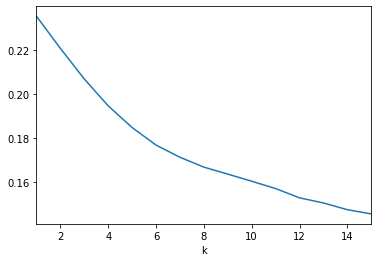

In [ ]:
 precisions_df.set_index("k")["avg_precision_at_k"].plot()

Precision quickly degradades when whe increase K. This is an indicative that recommendations stop being relevant

Trying different hyper-parameters to learn how they affect precision for k = 5

In [ ]:
model.model.iter

/usr/local/Caskroom/miniconda/base/envs/udacity_project/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


2

In [ ]:
#export
def hyper_parameter_tunning(epochs: List[int], windows: List[int], negatives: List[int], target_k: int, debug=False) -> Tuple[Word2VecMovieModel, GensimParameters, float]:
    best_model = None
    best_p = 0.0
    best_hyperparams = None
    for epoch, window, negative in product(epochs, windows, negatives):
        gensim_parameters = GensimParameters(compute_loss=False, window= window, iter=epoch, negative= negative)
        if debug:
            print("> Running for", gensim_parameters)
        model = Word2VecMovieModel(
            movies_df=movies_df,
            ratings_df=ratings_df,
            gensim_parameters=gensim_parameters
        )
        model.train()
        p = model.calculate_precision_at_k(target_k)
        if debug:
            print(f"p_at_{target_k}", p)
        if p > best_p:
            best_p = p
            best_model = model
            best_hyperparams = gensim_parameters
    if debug:
        print("> Best params ", best_p, best_hyperparams)
    return (best_model, best_hyperparams, best_p)

In [ ]:
epochs = [10, 20]
windows = [1, 5, 10, 20]
negatives = [1, 5, 10, 20]

result = hyper_parameter_tunning(epochs=epochs, windows=windows, negatives=negatives, target_k=5, debug=True)

> Running for GensimParameters(window=1, iter=10, sg=1, hs=0, negative=1, alpha=0.03, min_alpha=0.0007, seed=14, compute_loss=False)
p_at_5 0.19729102863666467
> Running for GensimParameters(window=1, iter=10, sg=1, hs=0, negative=5, alpha=0.03, min_alpha=0.0007, seed=14, compute_loss=False)
p_at_5 0.164802109320908
> Running for GensimParameters(window=1, iter=10, sg=1, hs=0, negative=10, alpha=0.03, min_alpha=0.0007, seed=14, compute_loss=False)
p_at_5 0.16845557669432906
> Running for GensimParameters(window=1, iter=10, sg=1, hs=0, negative=20, alpha=0.03, min_alpha=0.0007, seed=14, compute_loss=False)
p_at_5 0.16771542081712165
> Running for GensimParameters(window=5, iter=10, sg=1, hs=0, negative=1, alpha=0.03, min_alpha=0.0007, seed=14, compute_loss=False)
p_at_5 0.19685537749107418
> Running for GensimParameters(window=5, iter=10, sg=1, hs=0, negative=5, alpha=0.03, min_alpha=0.0007, seed=14, compute_loss=False)
p_at_5 0.20236466239793832
> Running for GensimParameters(window=5,

In [ ]:
#hide
# Code from: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#visualising-the-word-embeddings

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(word2vec_recommender.model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)